In [4]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [3]:
!pip install simpy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import random
from dataclasses import dataclass

import simpy
from typing import List
import logging
import pandas as pd

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:126: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [6]:
# Configuration variables
@dataclass
class Config:
    num_nodes: int
    num_input_nodes: int
    num_steps: int
    task_generation_rate: float  # Tasks per time unit
    worker_avg_operations: int
    operation_range: int
    worker_max_connections: int
    task_processing_time: int
    task_transfer_time: int
    seed: int

In [7]:
class Task:
    def __init__(self, config: Config, task_id, start_time):
        self.task_id = task_id
        self.operations = random.sample(range(1, config.operation_range + 1), config.worker_avg_operations)
        self.original_num_operations = len(self.operations)
        self.start_time = start_time
        self.config = config

In [8]:
class WorkerNode:
    def __init__(self, config: Config, env, node_id):
        self.config = config
        self.env = env
        self.node_id = node_id
        self.operations = set()
        self.work_queue = simpy.Store(self.env)
        self.connected_nodes = []

    def connect_node(self, other_node):
        logging.info(f"Worker {self.node_id} connecting to worker {other_node.node_id}")
        self.connected_nodes.append(other_node)

    def add_task(self, task):
        log(f"Worker {self.node_id} accepting task {task.task_id}")
        self.work_queue.put(task)

    def add_operation(self, operation):
        self.operations.add(operation)

    def process_task(self):
        while True:
            task = yield self.work_queue.get()
            log(f"Worker {self.node_id} processing task {task.task_id} requiring operations {task.operations}")
            if self.can_perform_operations(task):
                operation = self.get_matching_operation(task)
                log(f"Worker {self.node_id} performing operation {operation} on task {task.task_id}")
                task.operations.remove(operation)
                yield self.env.timeout(self.config.task_processing_time)
                if not task.operations:
                    log(f"Task {task.task_id} completed!")
                    record_task_completion(self.env.now, task)
                else:
                    self.add_task(task)  # Requeue it for more work
            else:
                log(f"Worker {self.node_id} forwarding task {task.task_id}")
                yield self.env.timeout(self.config.task_transfer_time)
                network.route(self, task)

    def can_perform_operations(self, task):
        return any(operation in task.operations for operation in self.operations)

    def get_matching_operation(self, task):
        return random.choice(list(set(self.operations) & set(task.operations)))

In [9]:
class RandomNetwork:
    # Setup network of random connections with num_input_nodes input nodes
    @staticmethod
    def setup_network(config: Config, worker_nodes: List[WorkerNode]) -> List[WorkerNode]:
        # connect the nodes in a random mesh
        for node in worker_nodes:
            connections_needed = config.worker_max_connections - len(node.connected_nodes)
            if connections_needed > 0:
                possible_connections = list(set(worker_nodes) - set(node.connected_nodes) - {node})
                [RandomNetwork.connect_nodes(node, new_connection) for new_connection
                 in random.sample(possible_connections, connections_needed)]
        return random.sample(worker_nodes, config.num_input_nodes)

    # Bidirectionally connect nodes
    @staticmethod
    def connect_nodes(node: WorkerNode, new_connection: WorkerNode):
        node.connect_node(new_connection)
        new_connection.connect_node(node)

    @staticmethod
    def route(from_node, task):
        # Send to a random recipient
        random.choice(from_node.connected_nodes).add_task(task)

In [10]:
def generate_tasks(config: Config, env: simpy.Environment, target_nodes: List[WorkerNode]):
    task_id = 0
    while True:
        # Generate a task with a small set of randomly chosen process steps
        task = Task(config, task_id, env.now)
        log(f"Generated task {task.task_id}")

        # Assign the task to a random worker node for processing
        random.choice(target_nodes).add_task(task)
        task_id += 1

        # Simulate the time between task generation
        yield env.timeout(round(random.expovariate(config.task_generation_rate)))


# Assign each node the ability to perform specific operations
def assign_skills(config: Config, worker_nodes: List[WorkerNode]) -> None:
    # Insure each skill is assigned once
    for operation in range(1, config.operation_range):
        random.choice(worker_nodes).add_operation(operation)
    # Insure each worker has at least one skill
    for node in worker_nodes:
        if len(node.operations) == 0:
            node.add_operation(random.randint(1, config.operation_range))
    # Add extra operations so on average each worker has worker_max_operations
    for counter in range(config.operation_range, config.num_nodes * config.worker_avg_operations):
        random.choice(worker_nodes).add_operation(random.randint(1, config.operation_range))
        counter += 1
    for node in worker_nodes:
        logging.info(f"Worker {node.node_id} can perform operations {node.operations}")


In [11]:
def record_task_completion(completion_time, task):
    completion_times.append(completion_time)
    task_ids.append(task.task_id)
    start_times.append(task.start_time)
    processing_times.append(completion_time - task.start_time)
    num_operations.append(task.original_num_operations)


def log(message):
    logging.info(f"{env.now} {message}")


def store_results():
    # write configuration
    # config = {'num_nodes': num_nodes, 'num_input_nodes': num_input_nodes, 'num_steps'}
    # write data
    df = pd.DataFrame(data={'completion_time': completion_times, 'task_id': task_ids, 'start_time': start_times,
                            'process_time': processing_times, 'num_operations': num_operations})
    df.to_csv('output.csv', index=False)  # TODO: use run name

In [33]:
c = Config(**{
    'num_nodes': 5,
    'num_input_nodes': 5,
    'num_steps': 10,
    'task_generation_rate': 0.1,  # Tasks per time unit
    'worker_avg_operations': 3,
    'operation_range': 10,
    'worker_max_connections': 2,
    'task_processing_time': 1,
    'task_transfer_time': 1,
    'seed': 0
})

In [38]:
# Tracking lists
completion_times = []
task_ids = []
start_times = []
processing_times = []
num_operations = []

# Create SimPy environment and initialize worker nodes
if c.seed:
    random.seed(c.seed)
logging.basicConfig(format='%(message)s', level=logging.INFO)
env = simpy.Environment()
network = RandomNetwork()

nodes = [WorkerNode(c, env, node_id)
         for node_id in range(c.num_nodes)]

assign_skills(c, nodes)

# Set up the network connections
entry_nodes = RandomNetwork.setup_network(c, nodes)
logging.info("Entry nodes are {}".format(sorted([node.node_id for node in entry_nodes])))

# Start the worker processes
[env.process(node.process_task()) for node in nodes]

# Start the task generator process
env.process(generate_tasks(c, env, entry_nodes))

# Run the simulation for a specific duration
sim_duration = 200  # Simulation duration in time units
env.run(until=sim_duration)
store_results()

Worker 0 can perform operations {8, 5}
Worker 1 can perform operations {2, 5, 6}
Worker 2 can perform operations {8, 9}
Worker 3 can perform operations {9, 3, 6, 7}
Worker 4 can perform operations {1, 4, 5}
Worker 0 connecting to worker 2
Worker 2 connecting to worker 0
Worker 0 connecting to worker 3
Worker 3 connecting to worker 0
Worker 1 connecting to worker 3
Worker 3 connecting to worker 1
Worker 1 connecting to worker 0
Worker 0 connecting to worker 1
Worker 2 connecting to worker 1
Worker 1 connecting to worker 2
Worker 4 connecting to worker 3
Worker 3 connecting to worker 4
Worker 4 connecting to worker 1
Worker 1 connecting to worker 4
Entry nodes are [0, 1, 2, 3, 4]
0 Generated task 0
0 Worker 3 accepting task 0
0 Worker 3 processing task 0 requiring operations [10, 5, 9]
0 Worker 3 performing operation 9 on task 0
1 Worker 3 accepting task 0
1 Worker 3 processing task 0 requiring operations [10, 5]
1 Worker 3 forwarding task 0
2 Worker 1 accepting task 0
2 Worker 1 process

In [14]:
completion_times

[9,
 10,
 20,
 26,
 33,
 47,
 56,
 57,
 59,
 66,
 70,
 70,
 81,
 87,
 108,
 112,
 148,
 181,
 189]

In [17]:
import numpy as np

In [35]:
processing_times

[18, 6, 9, 25, 9, 9, 22, 12, 14, 29]

In [39]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=processing_times, bins='auto', color='#0504aa', rwidth=0.85
#                            alpha=0.7, 
                           )
plt.grid(axis='y')
plt.xlabel('Completion steps')
plt.ylabel('Frequency')
plt.title('Completion analysis')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


(0.0, 10.0)

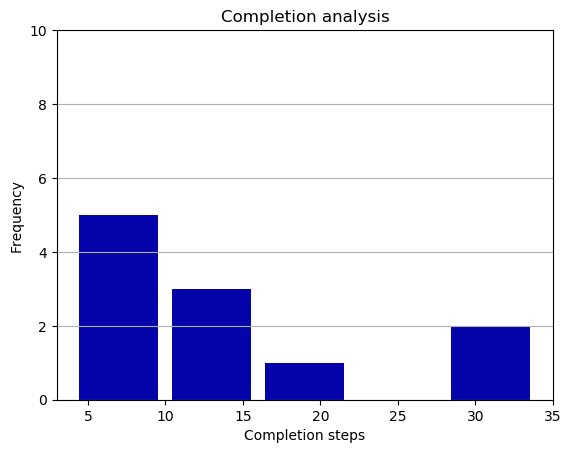

In [40]:
plt.show()